In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
import scipy.stats as sps

import pickle

import arviz as az
import pyjags

from IPython.display import HTML, Latex, Markdown, clear_output

# Abstract

A simple method is presented to estimate effective reproduction number $R_t$ of COVID-19 in italian regions with a Markov chain Monte Carlo and Poisson likelihood parametrized on daily new cases.

# Method

New cases $y_r$ for each $r$ italian regions (source [Dipartimento Protezione Civile](https://github.com/pcm-dpc/COVID-19)), will be smoothed with rolling mean (gaussian, window 7, std 2). Smoothed new cases will be adjusted to be $>0$ to avoid negative values (due to data error corrections).

For each day $t$, smoothed new cases $y_{r,t}$ will be supposed distributed as **Poisson** with $\lambda_{r,t}$ parameter

$$
y_{r,t} \sim \mathcal{P}(\lambda_{r,t})
$$

where $\lambda_{r,t}$ is defined by the serial interval inverse $\gamma$, previous day smoothed new cases $k_{r,t-1}$ and effective reproduction number in time $R_{r,t}$ (ref: [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185))

$$
\lambda_{r,t} = k_{r,t-1} e^{\gamma (R_{r,t} - 1)}
$$

In [2]:
SI_mu = 7.5
SI_sd = 3.4

In [3]:
display(Markdown(fr"""
The serial interval **SI** is supposed to be distributed as **Gamma**, 
with mean $\mu={SI_mu}$ and standard deviation $\sigma={SI_sd}$
(ref: [Li, Ghuan et Al. 2020a](https://www.sciencedirect.com/science/article/pii/S2468042720300063#bib6))

$$
\mathbf{{SI}} \sim \Gamma(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$

so that $\gamma$ is distributed as **Inverse Gamma**

$$
\gamma \sim \Gamma^{{-1}}(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$
"""))


The serial interval **SI** is supposed to be distributed as **Gamma**, 
with mean $\mu=7.5$ and standard deviation $\sigma=3.4$
(ref: [Li, Ghuan et Al. 2020a](https://www.sciencedirect.com/science/article/pii/S2468042720300063#bib6))

$$
\mathbf{SI} \sim \Gamma(\mu_{=7.5}, \sigma_{=3.4})
$$

so that $\gamma$ is distributed as **Inverse Gamma**

$$
\gamma \sim \Gamma^{-1}(\mu_{=7.5}, \sigma_{=3.4})
$$


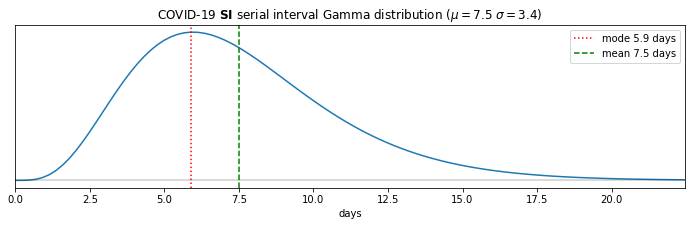

In [4]:
shape = SI_mu**2 / SI_sd**2 
scale = SI_sd**2 / SI_mu
SI_dist = sps.gamma(a=shape, scale=scale)
SI_x = np.linspace(SI_dist.ppf(0), SI_dist.ppf(.999), 100)
SI_y = SI_dist.pdf(SI_x)

omega = SI_x[SI_y.argmax()]
mean = SI_dist.stats(moments="m")

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(SI_x, SI_y)
ax.axvline(omega, c="r", ls=":", label=f"mode {omega:.1f} days")
ax.axvline(mean, c="g", ls="--", label=f"mean {mean:.1f} days")

ax.legend()
ax.axhline(0, c="k", alpha=.2)
ax.set_xlim(0, SI_x.max())
ax.set_yticks([])
ax.set_xlabel("days")
ax.set_title(fr"COVID-19 $\mathbf{{SI}}$ serial interval Gamma distribution ($\mu={SI_mu}$ $\sigma={SI_sd}$)")
plt.show();

Parameters $R_{{r,t}}$ will be distributed as half normal with mean equal to previous day posteriors 
$R_{{r,t-1}}$ and unknown precision $\tau$

$$
R_{{r,t}} \sim \mathcal{{N}}^+(R_{{r,t-1}}, \tau)
$$

where, first day $R_{{r,0}}$ (outcome) 
is set to zero

$$
R_{{r,0}} = 0
$$

and $\tau$ priors are distributed **Gamma** (partial pooling between regions) with shape and rate based on results of preliminary tests with uniformative $\tau$ distribution

$$
\tau \sim \Gamma(1000, 100)
$$

so that the standard deviation $\sigma$ will be

$$
\sigma = \frac{1}{\sqrt{\tau}}
$$

If previous new cases are zero $k_{r,t-1}=0$, parameter $R_{r,t}$ is undefined, given the chosen function for $\lambda_{r,t}$ parameter of Poisson likelihood, even if it should be $R_{r,t}=0$ (no new cases means null effective reproduction number). Thus, in these cases, priors of $R_{r,t}$ will be forced to

$$
R_{r,t} \sim \mathcal{N}^+(0, \tau)
\;,\; k_{r,t-1}=0
$$

and previous new cases will be forced to $k_{r,t-1}=1$, so that $\lambda_{r,t}$ will be

$$
\lambda_{r,t} = e^{\gamma( \mathcal{N}^+(0, \tau) - 1 )}
\;,\; k_{r,t-1}=0
$$

The mean of $\tau$ posteriors, will be used to calculate $R_t$ for Italy as a nation with the same model (except $\tau$ will be fixed instead of distributed).

In [5]:
adapt = 500
warmup = 1000
sample = 1000

In [6]:
display(Markdown(f"""
A Markov chain Monte Carlo will be used with Metropolis-Hasting algorithm and Gibbs sampler 
(adapt {adapt}, warmup {warmup}, samples {sample}, chains 4, thin 1) in `Python 3.8.5` with `pyjags==1.3.7`
and `JAGS 4.3.0` for macOS.
"""))


A Markov chain Monte Carlo will be used with Metropolis-Hasting algorithm and Gibbs sampler 
(adapt 500, warmup 1000, samples 1000, chains 4, thin 1) in `Python 3.8.5` with `pyjags==1.3.7`
and `JAGS 4.3.0` for macOS.


The jupyter notebook backend is available at [GitHub](link).

In [7]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()
days = df.index.get_level_values("data").unique()

In [8]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()

In [9]:
Y = np.ndarray(shape=(countries.size, days.size))

yit = it.rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
yit[yit<0] = 0

for r, region in enumerate(countries):

    y = df.loc[region]
    lom = df.loc[region].rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
    lom[lom<0] = 0
    
    Y[r] = lom
    
model_data = {
    "y": Y,
    "k": Y,
    "C": countries.size,
    "T": days.size
}

In [10]:
modelString = f"""
model {{
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    for ( r in 1:C ) {{
        # First Rt prior
        R[r,1] <- 0
        for ( t in 2:T ) {{
            # Rt prior for k>0
            Rpr[r,t] ~ dnorm( R[r,t-1] , tau_R )  T(0,)
            # Rt prior for k=0
            Rnu[r,t] ~ dnorm( 0 , tau_R )  T(0,)

            # Define Rt prior
            R[r,t] <- ifelse( k[r,t-1]==0 , Rnu[r,t] , Rpr[r,t] )
            # Avoid k=0 (undefined Rt)
            K[r,t] <- ifelse( k[r,t-1]==0, 1 , k[r,t-1] )

            # Poisson likelihood
            lambda[r,t] <- K[r,t] * exp( gamma * ( R[r,t] - 1 ) )
            y[r,t] ~ dpois( lambda[r,t] )
        }}
    }}
}}
"""

In [11]:
display(Markdown(f"```R\n{modelString}\n```"))

```R

model {
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- 7.5
    SI_sd <- 3.4
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    for ( r in 1:C ) {
        # First Rt prior
        R[r,1] <- 0
        for ( t in 2:T ) {
            # Rt prior for k>0
            Rpr[r,t] ~ dnorm( R[r,t-1] , tau_R )  T(0,)
            # Rt prior for k=0
            Rnu[r,t] ~ dnorm( 0 , tau_R )  T(0,)

            # Define Rt prior
            R[r,t] <- ifelse( k[r,t-1]==0 , Rnu[r,t] , Rpr[r,t] )
            # Avoid k=0 (undefined Rt)
            K[r,t] <- ifelse( k[r,t-1]==0, 1 , k[r,t-1] )

            # Poisson likelihood
            lambda[r,t] <- K[r,t] * exp( gamma * ( R[r,t] - 1 ) )
            y[r,t] ~ dpois( lambda[r,t] )
        }
    }
}

```

Standard deviation $\sigma$ prior with chosen $\tau$ distribution

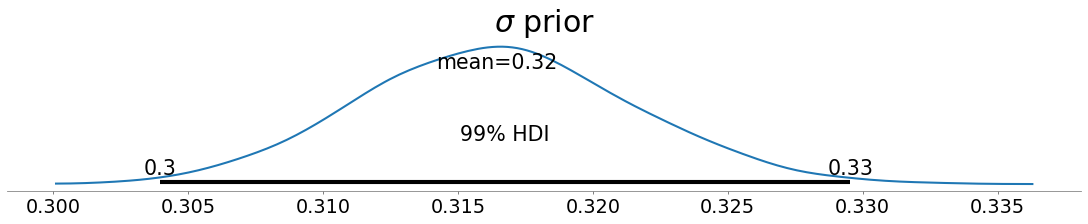

In [12]:
sigmaModelString = """
model {
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )
}
"""

jags_model_sigma = pyjags.Model(
    code=sigmaModelString, 
    chains=4, 
    adapt=500,
    progress_bar=False
)

jags_sigma_priors = jags_model_sigma.sample(500 + 1000, vars=["sigma_R"])

pyjags_data_sigma = az.from_pyjags(
    jags_sigma_priors,
    warmup_iterations=100, save_warmup=False)

ax = az.plot_posterior(
    pyjags_data_sigma,
    hdi_prob=.99,
    figsize=(15,3)
)
ax[0].set_title(fr"$\sigma$ prior", fontsize=30)
plt.show()
plt.close(fig="all")

# Posteriors

In [13]:
jags_posteriors = None

In [14]:
_ = """adapt = 50
warmup = 50
sample = 50"""

print("Starting MCMC...")

jags_model = pyjags.Model(
    code=modelString, 
    data=model_data,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors = jags_model.sample(warmup + sample, vars=["R", "sigma_R", "tau_R"])

clear_output()
print("DONE!")

with open("posterior_samples.pkl", "wb") as f:
    pickle.dump(jags_posteriors, f)

DONE!


In [15]:
if not jags_posteriors:
    with open("posterior_samples.pkl", "rb") as f:
        jags_posteriors = pickle.load(f)

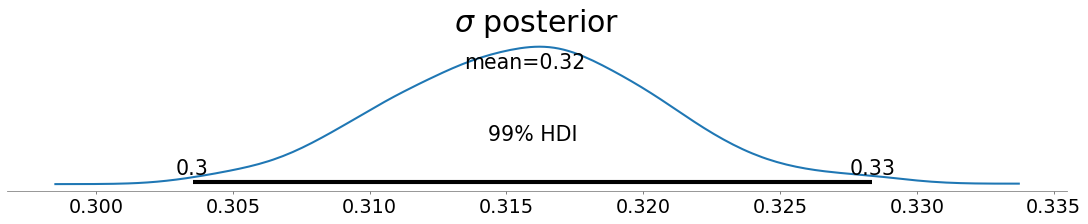

## Abruzzo

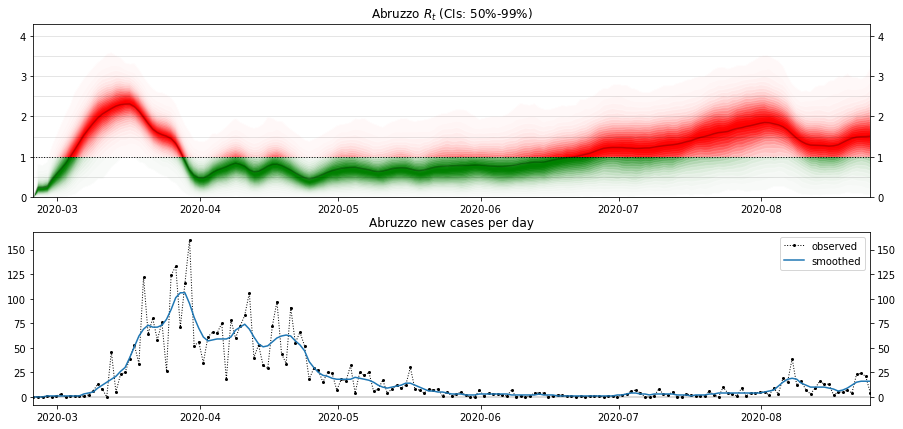

***

## Basilicata

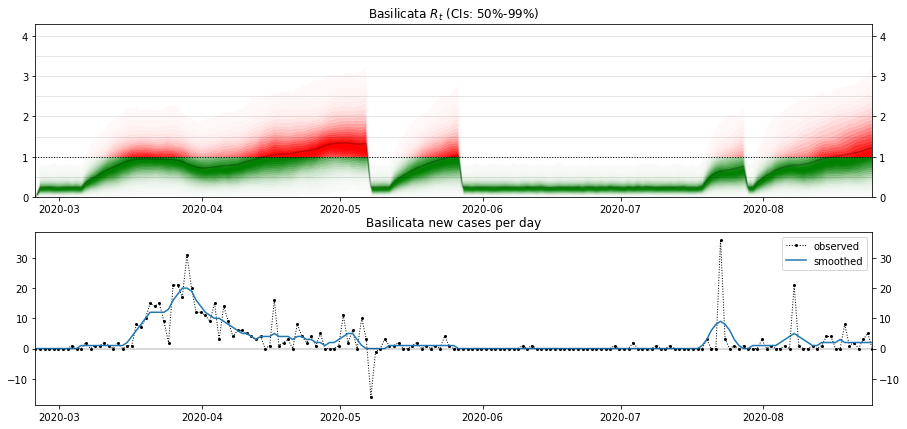

***

## Calabria

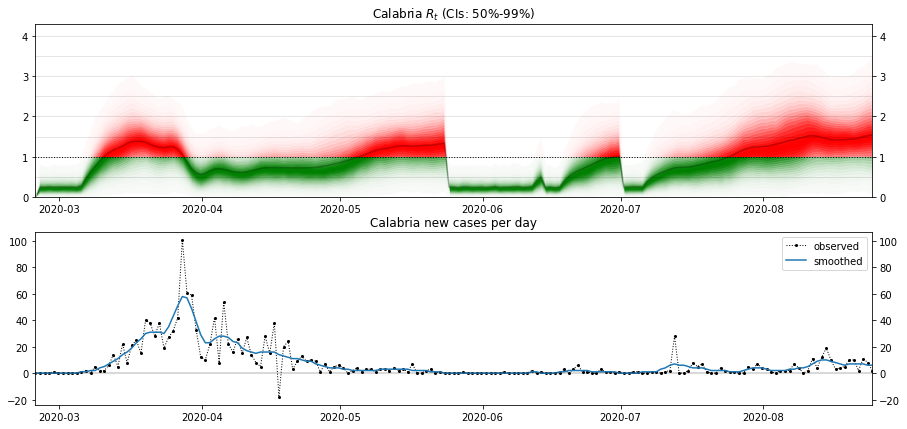

***

## Campania

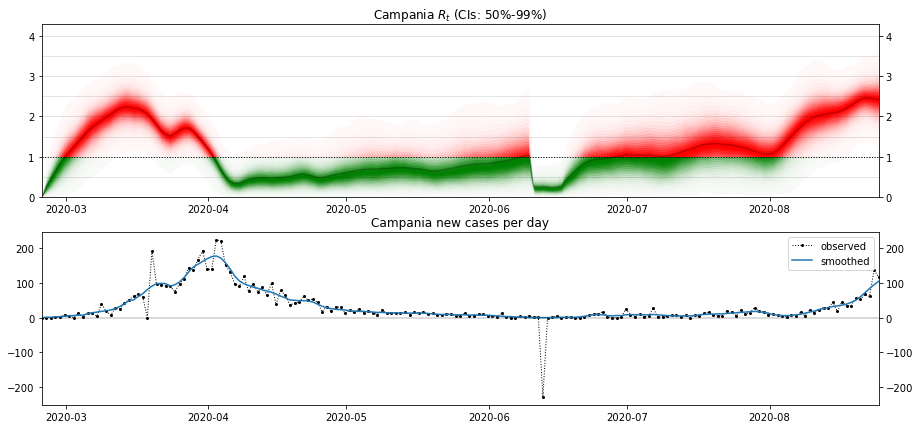

***

## Emilia-Romagna

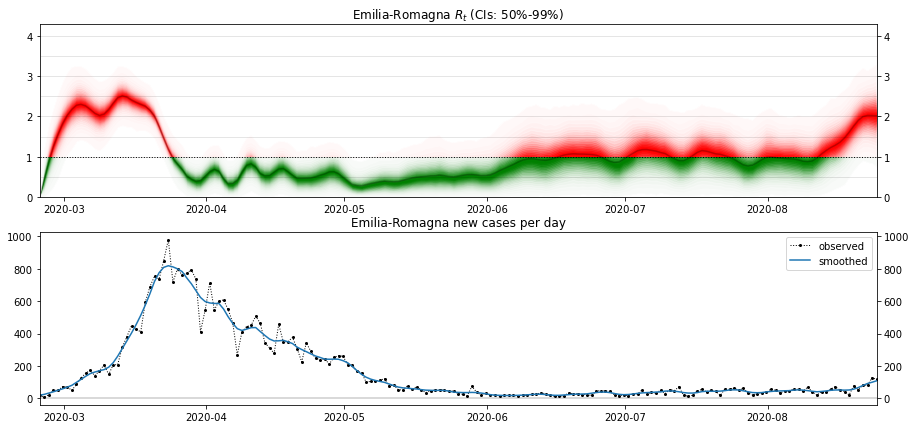

***

## Friuli Venezia Giulia

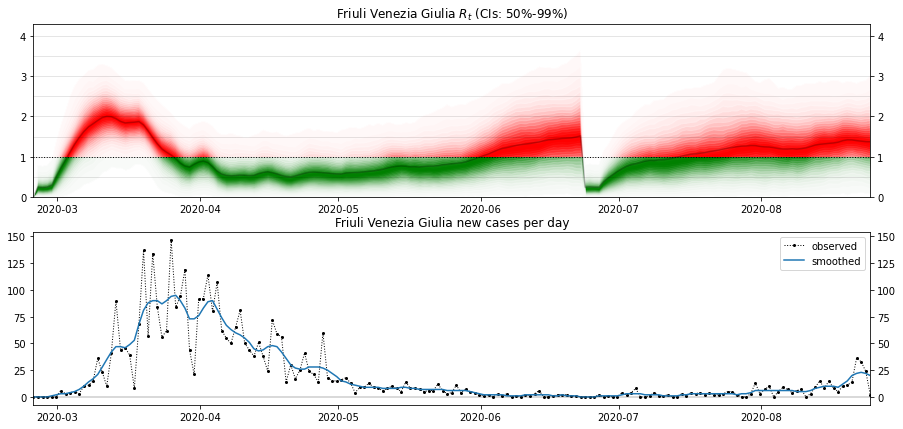

***

## Lazio

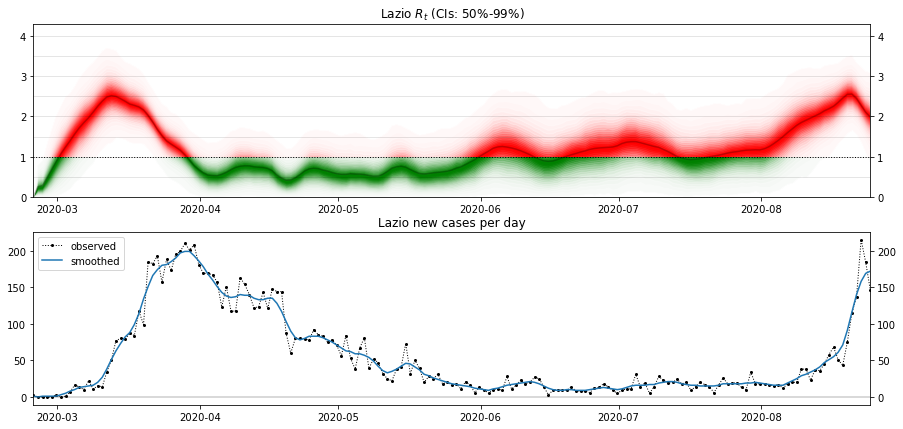

***

## Liguria

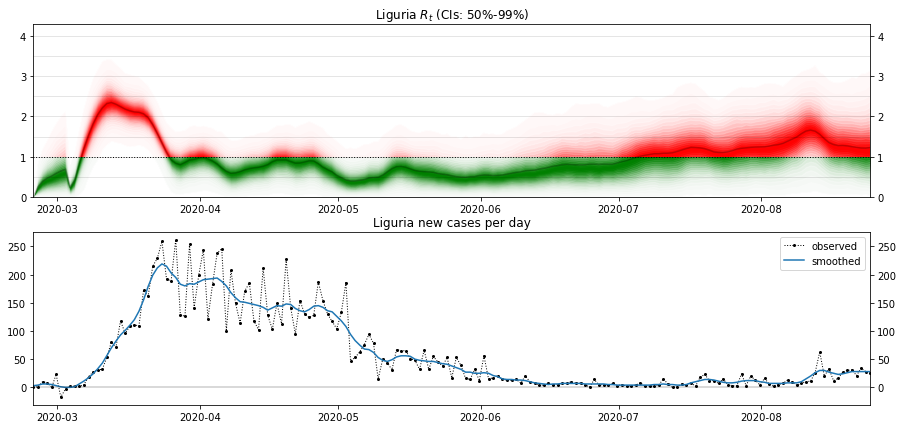

***

## Lombardia

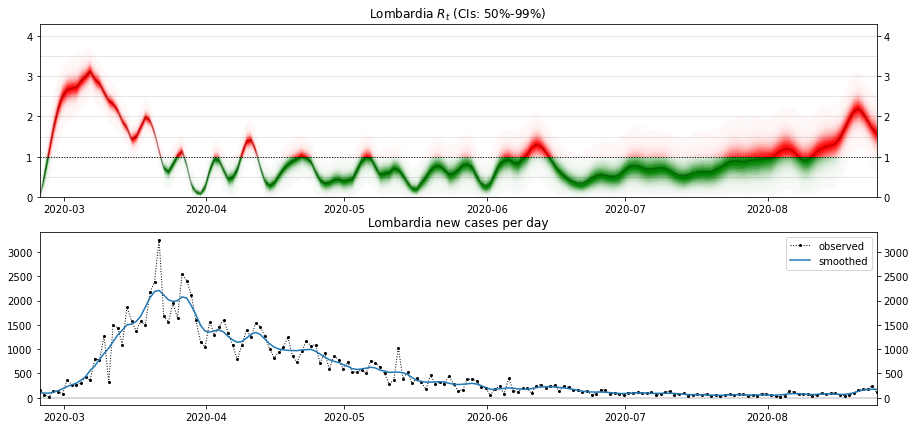

***

## Marche

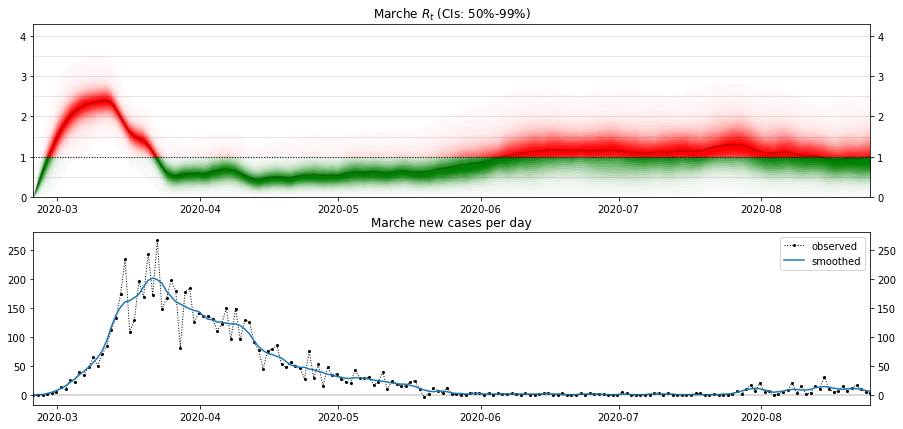

***

## Molise

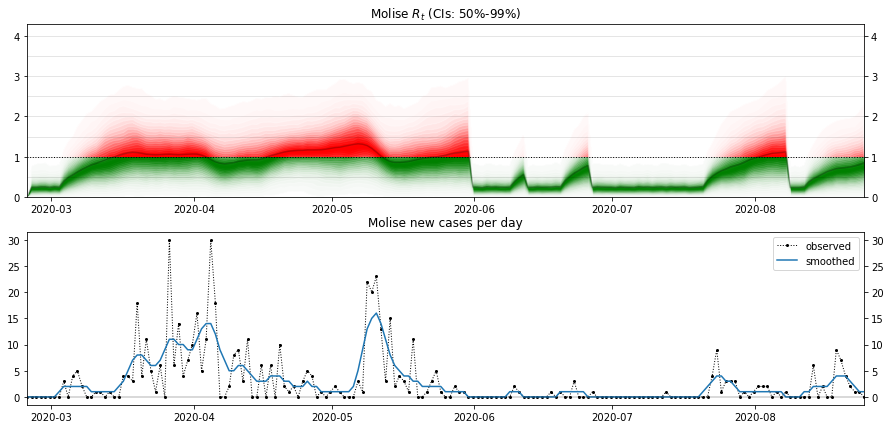

***

## P.A. Bolzano

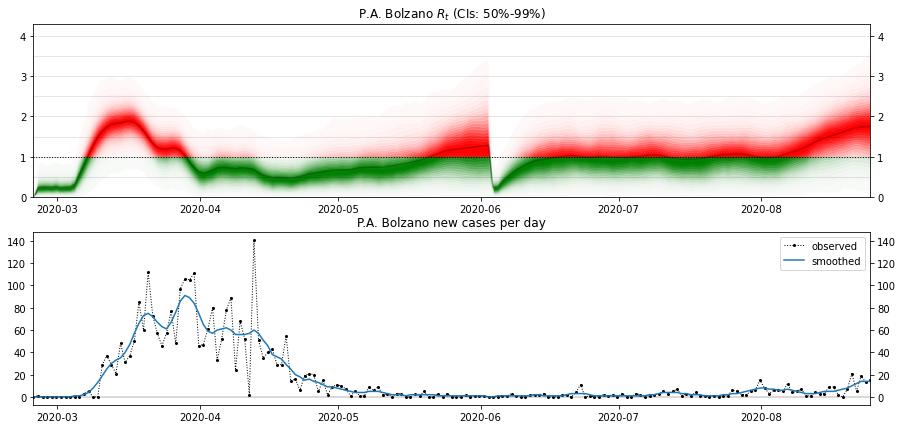

***

## P.A. Trento

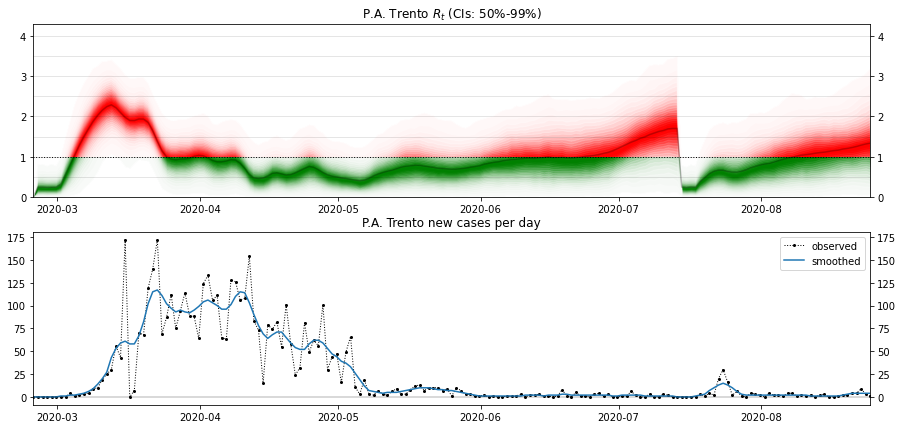

***

## Piemonte

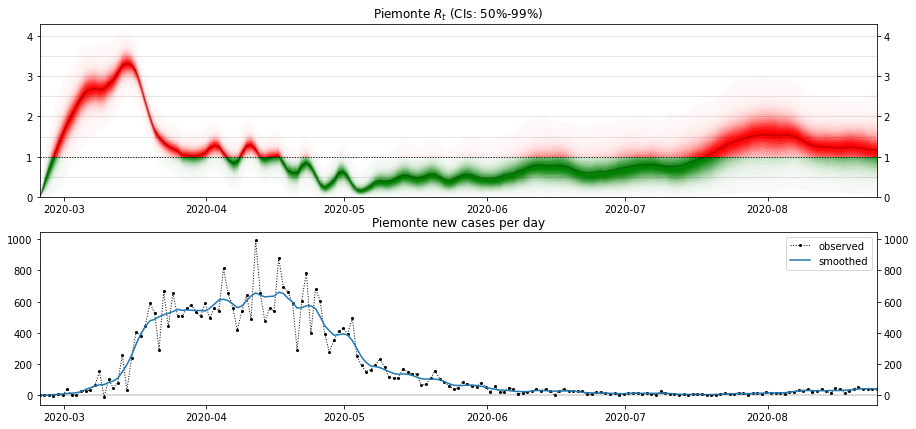

***

## Puglia

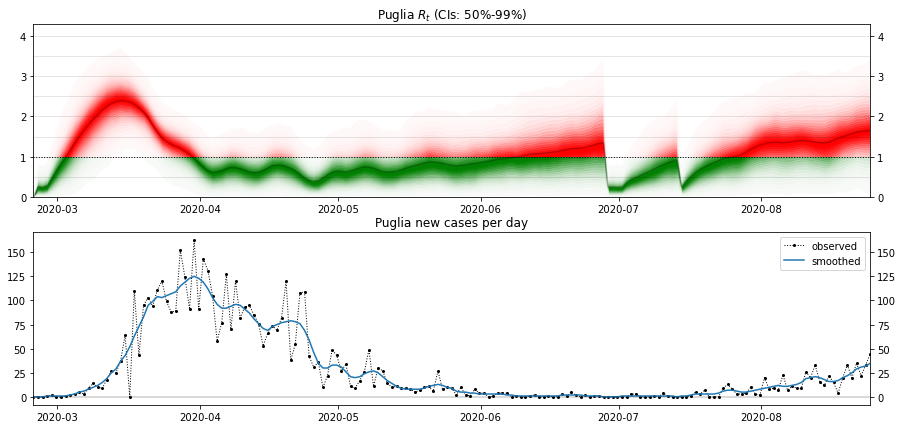

***

## Sardegna

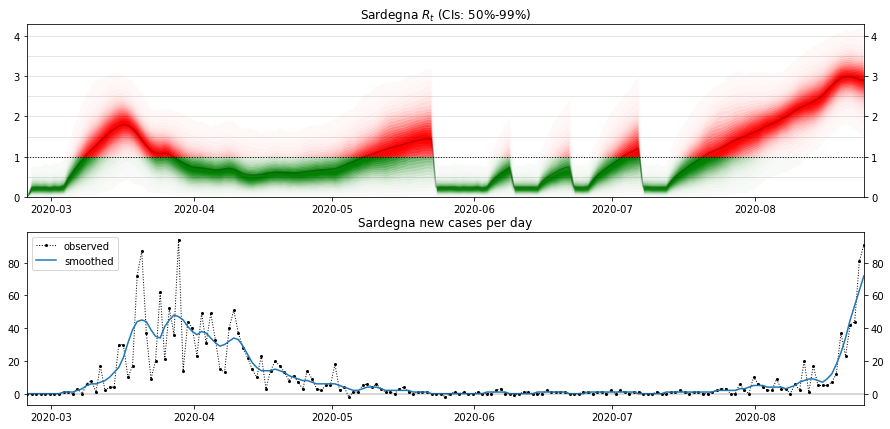

***

## Sicilia

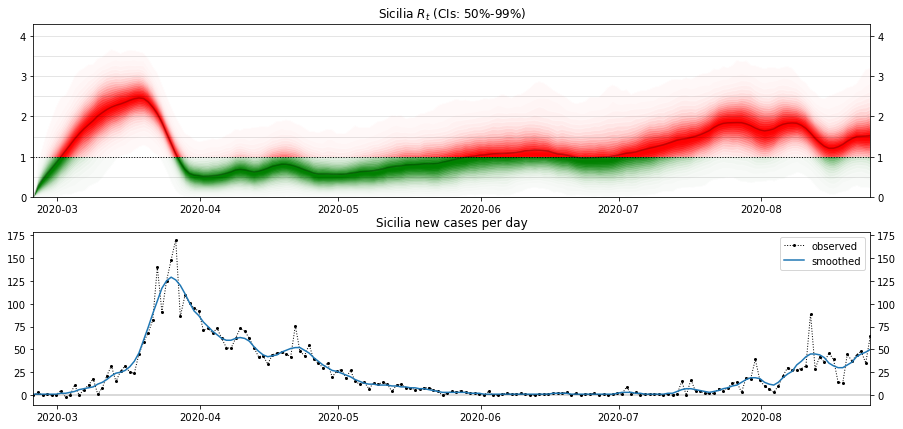

***

## Toscana

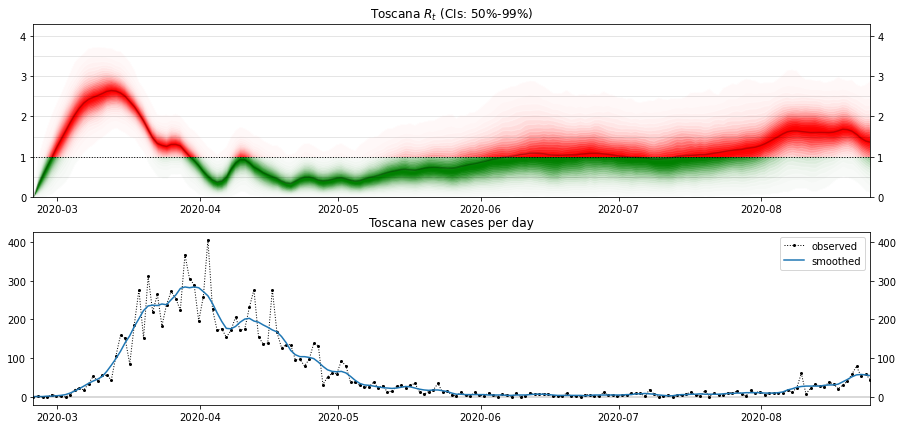

***

## Umbria

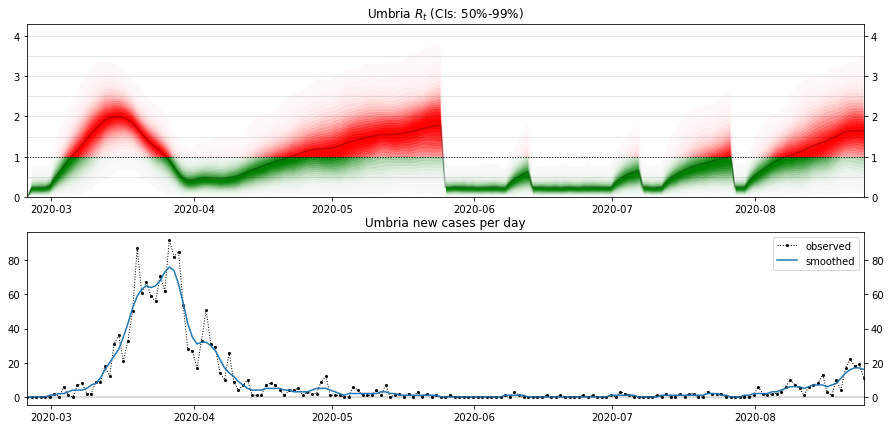

***

## Valle d'Aosta

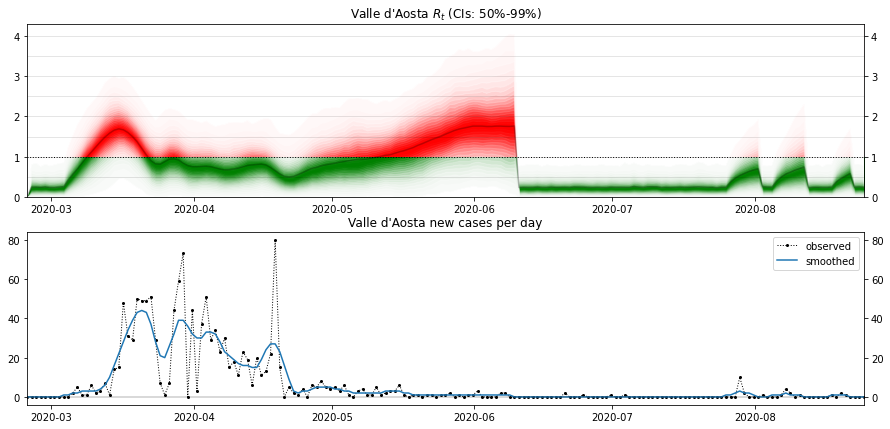

***

## Veneto

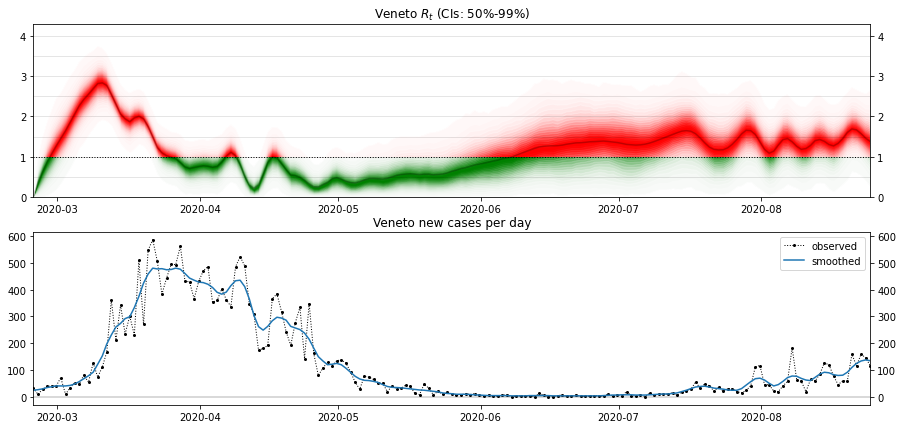

***

In [16]:
percs = np.linspace(50, 99, 20)

pyjags_data_sigma = az.from_pyjags(
    {"sigma_R": jags_posteriors["sigma_R"]},
    warmup_iterations=warmup, save_warmup=False)

ax = az.plot_posterior(
    pyjags_data_sigma,
    hdi_prob=.99,
    figsize=(15,3)
)
ax[0].set_title(fr"$\sigma$ posterior", fontsize=30)
plt.show()
plt.close(fig="all")

ymax = np.array([])
uppers = np.ndarray(shape=(countries.size, len(percs), days.size))
lowers = np.ndarray(shape=(countries.size, len(percs), days.size))
means = np.ndarray(shape=(countries.size, days.size))
for r, region in enumerate(countries):
    
    pyjags_data_test = az.from_pyjags({"R": jags_posteriors["R"][r]}, warmup_iterations=warmup, save_warmup=False)
    summary = az.summary(pyjags_data_test, var_names="^R", filter_vars="regex", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data_test.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data_test.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper[2:].max())
        uppers[r,i] = upper
        lowers[r,i] = lower
        means[r] = summary["mean"]
ymax = ymax.max()

for r, region in enumerate(countries):
        
    display(Markdown(f"## {region}"))
    
    fig, ax = plt.subplots(2, 1, figsize=(15,7))

    ax[1].plot(days, df.loc[region].values, 'ok:', lw=1, ms=2, label="observed")
    ax[1].plot(days, Y[r], label="smoothed")
    ax[1].axhline(0, c="k", alpha=.2)
    ax[1].set_xlim(days[0], days[-1])
    ax[1].yaxis.set_ticks_position('both')
    ax[1].tick_params(labelright=True)
    ax[1].legend()
    ax[1].set_title(f"{region} new cases per day")

    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r], lowers[r])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax[0].plot(days, means[r], c="k", alpha=.25)

    ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
    ax[0].axhline(1, c="k", ls=":", lw=1)

    ax[0].fill_between(days, 1, 12, color="red", zorder=0)
    ax[0].fill_between(days, 0, 1, color="green", zorder=0)

    ax[0].set_xlim(days[0], days[-1])

    ax[0].set_title(fr"{region} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
    
    ax[0].set_ylim(0, ymax)
    ax[0].yaxis.set_ticks_position('both')
    ax[0].tick_params(labelright=True)
    
    plt.show()
    plt.close(fig="all")
    
    display(Markdown("***"))

## Latest Rt

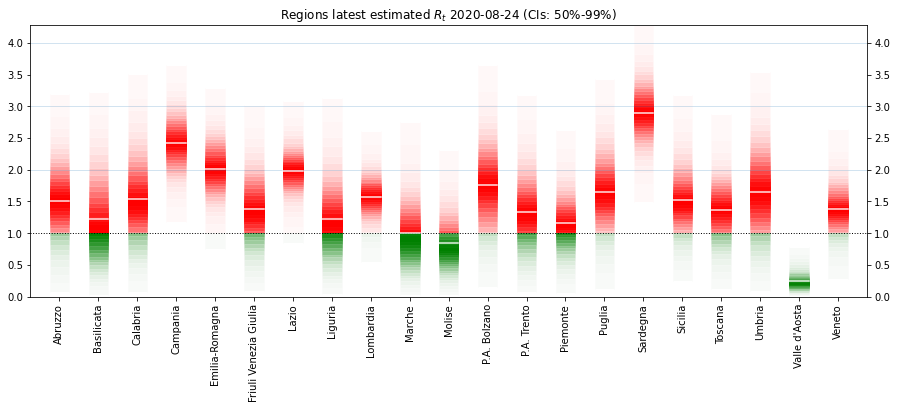

In [17]:
fig, ax = plt.subplots(figsize=(15,5))

for r, region in enumerate(countries):
    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r,:,-1], lowers[r,:,-1])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.fill_between([r*2,r*2+1], 1, 12, color="red", zorder=0)
        ax.fill_between([r*2,r*2+1], 0, 1, color="green", zorder=0)
        ax.fill_between(np.linspace(r*2,r*2+1,10), np.zeros(10), lower, color="w", alpha=alpha)
        ax.fill_between(np.linspace(r*2,r*2+1,10), upper, np.ones(10)*12, color="w", alpha=alpha)
    ax.plot(np.linspace(r*2,r*2+1,10), np.ones(10)*means[r][-1], color="w", alpha=.9, zorder=100)

ax.axhline(1, c="k", ls=":", lw=1)
ax.hlines(np.arange(2, 12, 1), -1, countries.size*2+1, lw=1, alpha=.2)
ax.set_ylim(0, ymax)
ax.set_xlim(-1, countries.size*2)
ax.set_xticks(np.arange(.5, countries.size*2+.5, 2))
ax.set_xticklabels(countries.values, rotation=90)
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelright=True)
ax.set_title(f"Regions latest estimated $R_t$ {days[-1].date()} (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
plt.show();

## Italy

In [18]:
pyjags_data_tau = az.from_pyjags(
    {"tau_R": jags_posteriors["tau_R"]}, 
    warmup_iterations=warmup, save_warmup=False)

summary_tau = az.summary(pyjags_data_tau)

modelStringItaly = f"""
model {{
    # Estimated Rt precision tau
    tau_R <- {summary_tau['mean'][0]}
    
    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
}}
"""

In [19]:
display(Markdown(f"```R\n{modelStringItaly}\n```"))

```R

model {
    # Estimated Rt precision tau
    tau_R <- 10.044
    
    # Serial interval distribution
    SI_mu <- 7.5
    SI_sd <- 3.4
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }
}

```

In [20]:
model_data_italy = {
    "y": yit,
    "k": yit,
    "T": days.size
}

In [21]:
jags_posteriors_italy = None

_ = """adapt = 50
warmup = 50
sample = 50"""

print("Starting MCMC...")

jags_model_italy = pyjags.Model(
    code=modelStringItaly, 
    data=model_data_italy,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors_italy = jags_model_italy.sample(warmup + sample, vars=["R"])

clear_output()
print("DONE!")

with open("posterior_samples_italy.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy, f)

DONE!


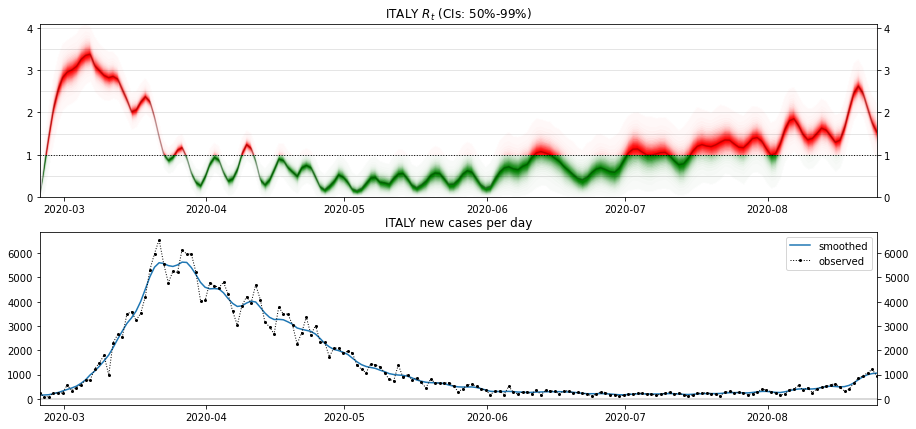

In [22]:
percs = np.linspace(50, 99, 20)

if not jags_posteriors_italy:
    with open("posterior_samples_italy.pkl", "rb") as f:
        jags_posteriors_italy = pickle.load(f)

ymax = np.array([])
uppers = np.ndarray(shape=(len(percs), days.size))
lowers = np.ndarray(shape=(len(percs), days.size))

pyjags_data_italy = az.from_pyjags(jags_posteriors_italy, warmup_iterations=warmup, save_warmup=False)
summary = az.summary(pyjags_data_italy, var_names="^R", filter_vars="regex", kind="stats")
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(pyjags_data_italy.posterior.R, p, axis=1)
    upper = np.mean(upper, axis=0)
    lower = np.percentile(pyjags_data_italy.posterior.R, 100-p, axis=1)
    lower = np.mean(lower, axis=0)
    ymax = np.append(ymax, upper.max())
    uppers[i] = upper
    lowers[i] = lower
ymax = ymax.max()

        
fig, ax = plt.subplots(2, 1, figsize=(15,7))

ax[1].plot(days, yit, label="smoothed")
ax[1].plot(days, it, 'ok:', lw=1, ms=2, label="observed")
ax[1].axhline(0, c="k", alpha=.2)
ax[1].set_xlim(days[0], days[-1])
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(labelright=True)
ax[1].legend()
ax[1].set_title(f"ITALY new cases per day")

steps = .4/(len(percs)-1)
for i, (upper, lower) in enumerate(zip(uppers, lowers)):
    alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
    ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
    ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

ax[0].plot(days, summary["mean"], c="k", alpha=.25)

ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
ax[0].axhline(1, c="k", ls=":", lw=1)

ax[0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
ax[0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

ax[0].set_xlim(days[0], days[-1])

ax[0].set_title(fr"ITALY $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

ax[0].set_ylim(0, ymax)
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(labelright=True)

plt.show()
plt.close(fig="all")

# MCMC diagnosis

## sigma

In [23]:
pyjags_data_sigma = az.from_pyjags(
    {"sigma_R": jags_posteriors["sigma_R"]}, 
    warmup_iterations=warmup, save_warmup=False)

In [24]:
display(HTML(az.summary(pyjags_data_sigma, hdi_prob=.99).to_html()))

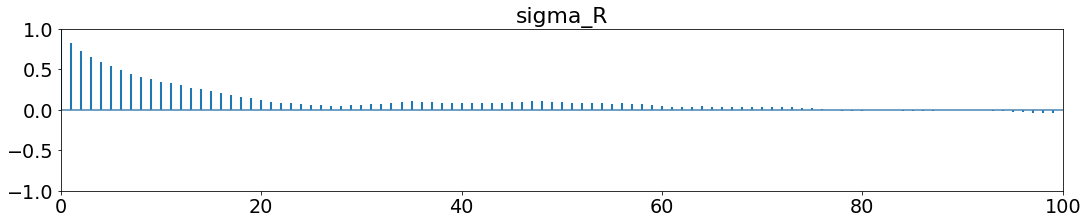

In [25]:
ax = az.plot_autocorr(
    pyjags_data_sigma,
    combined=True,
    max_lag=100,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

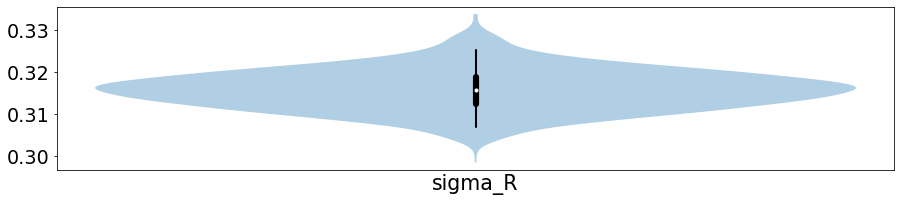

In [26]:
ax = az.plot_violin(
    pyjags_data_sigma,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

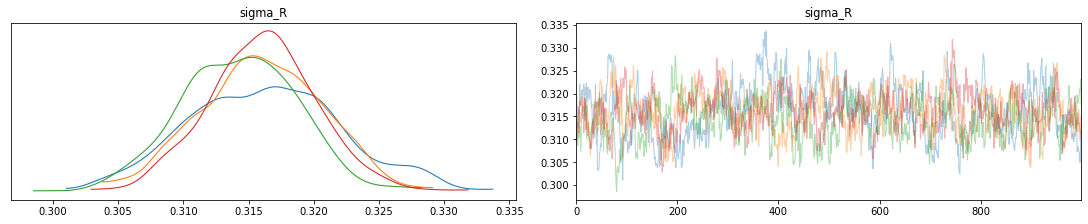

In [27]:
ax = az.plot_trace(
    pyjags_data_sigma,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

## Rt

### Abruzzo

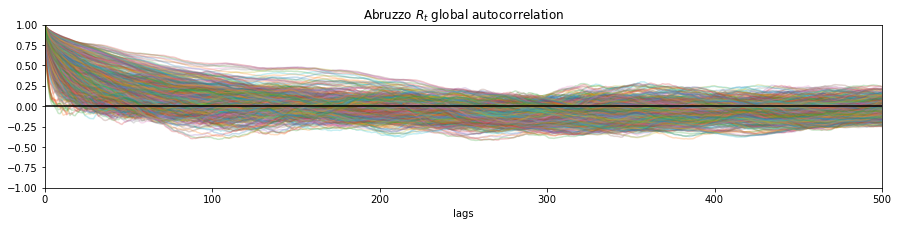

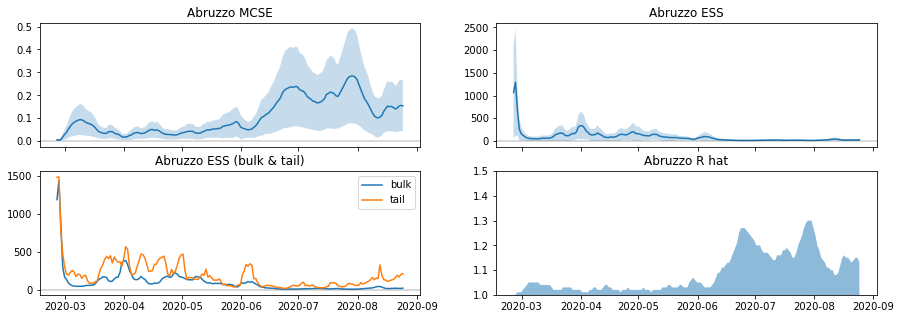

### Basilicata

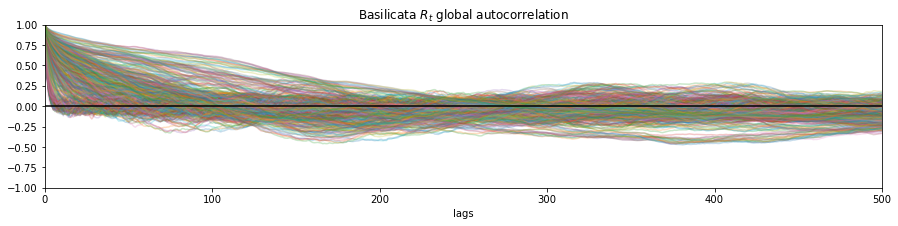

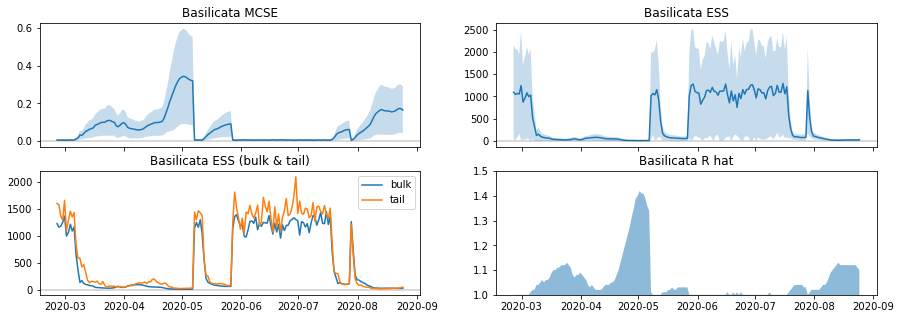

### Calabria

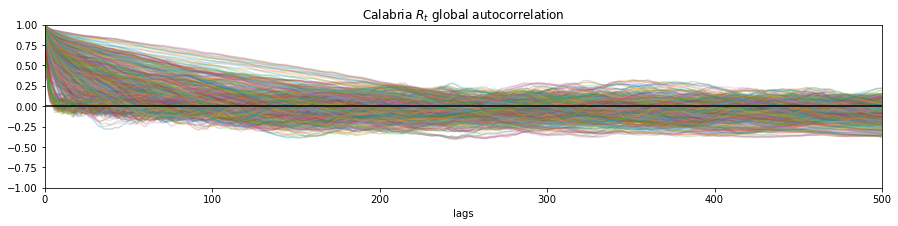

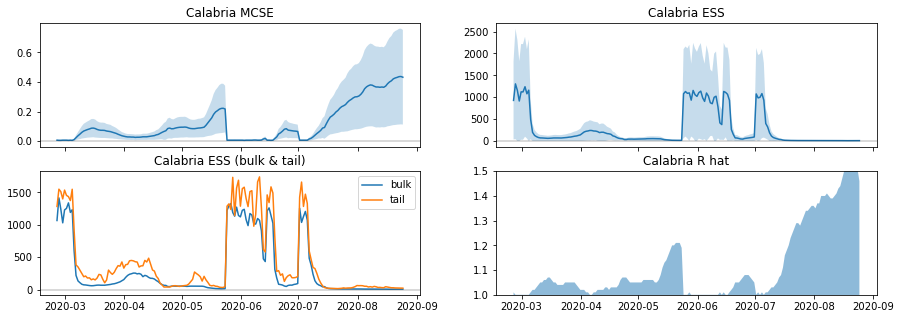

### Campania

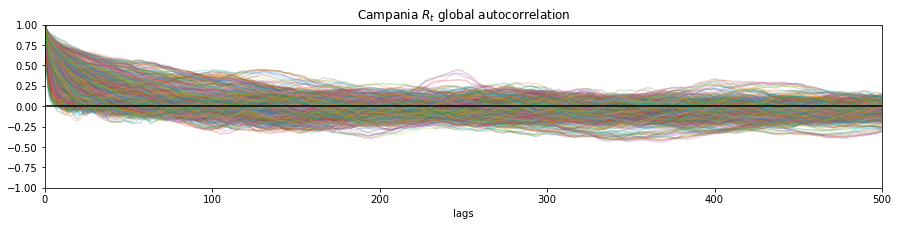

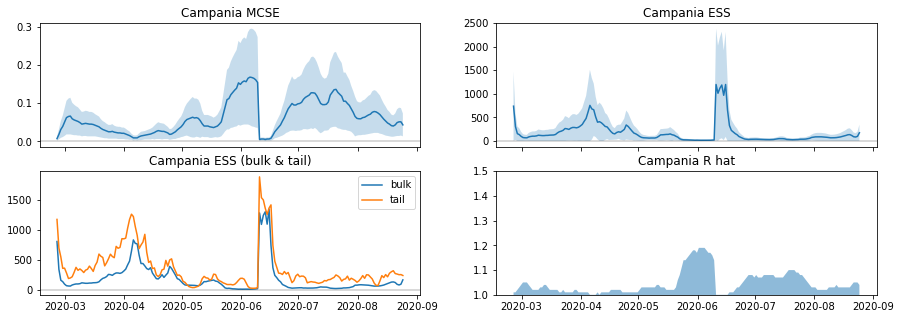

### Emilia-Romagna

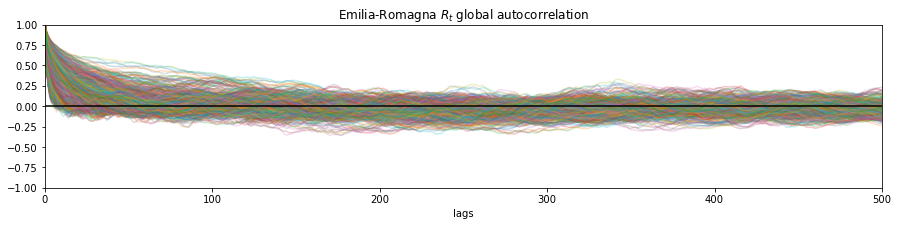

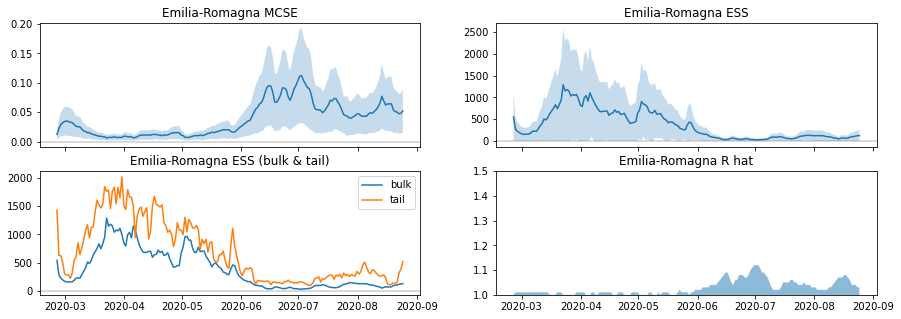

### Friuli Venezia Giulia

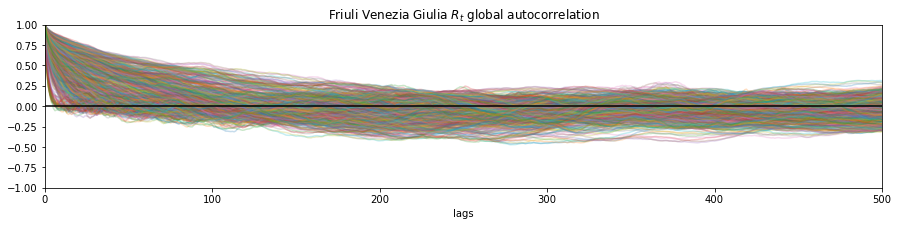

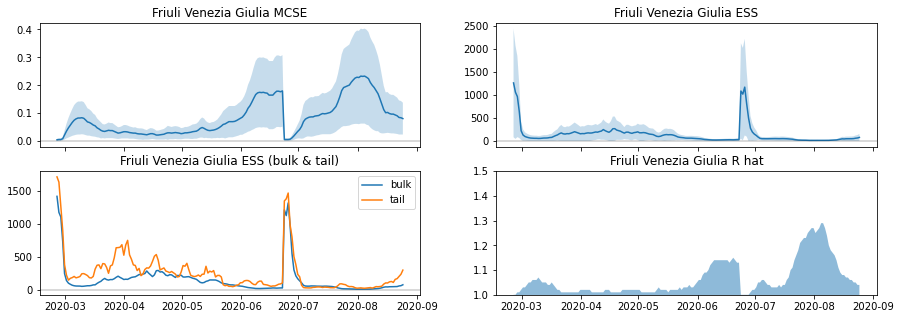

### Lazio

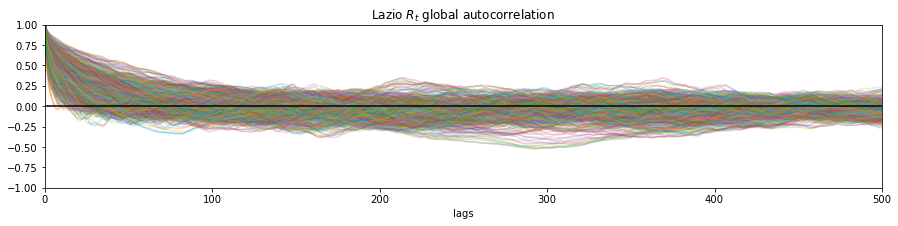

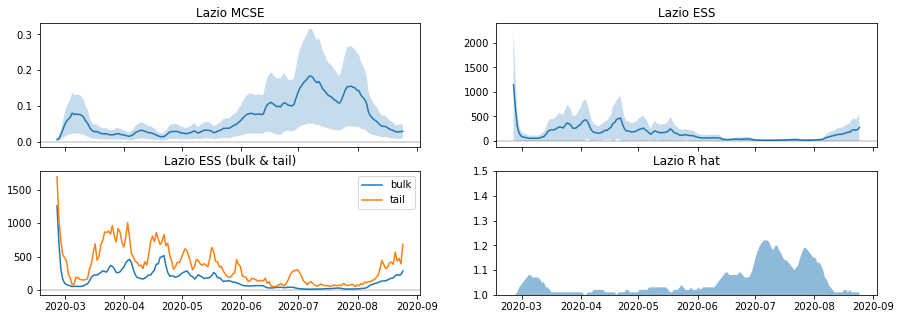

### Liguria

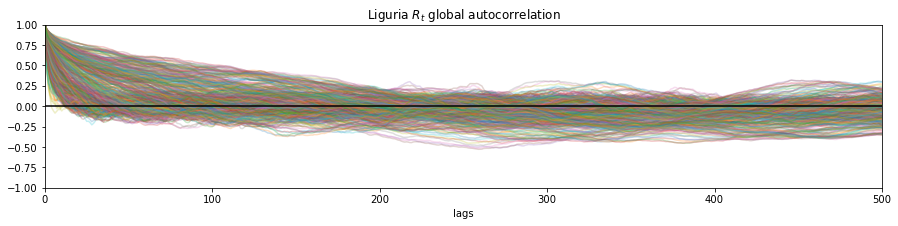

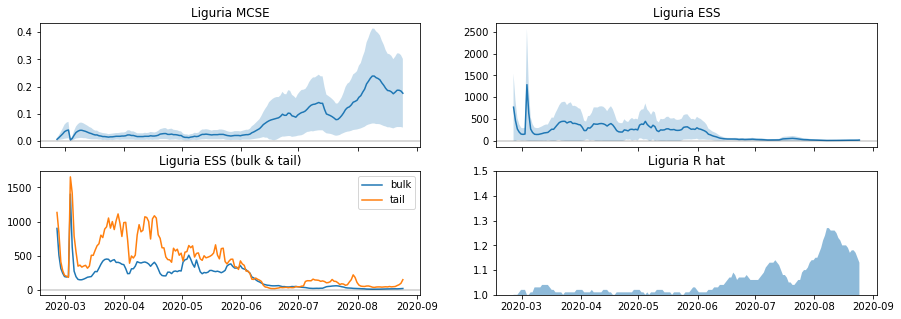

### Lombardia

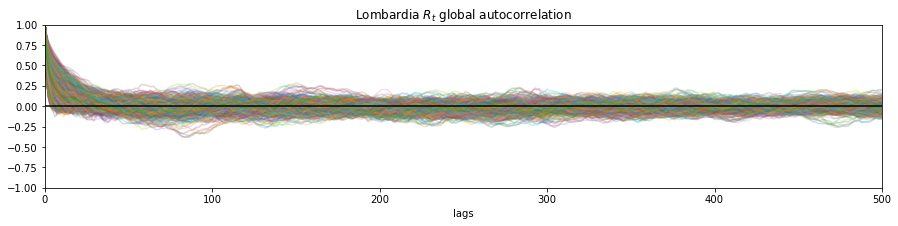

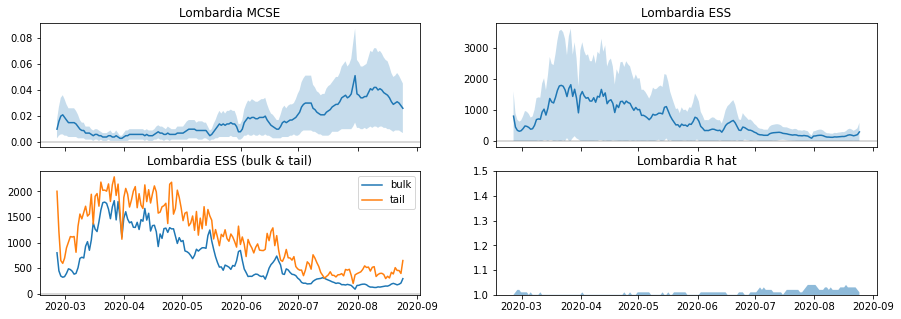

### Marche

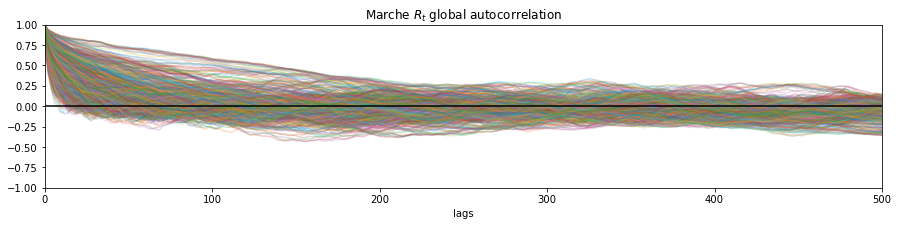

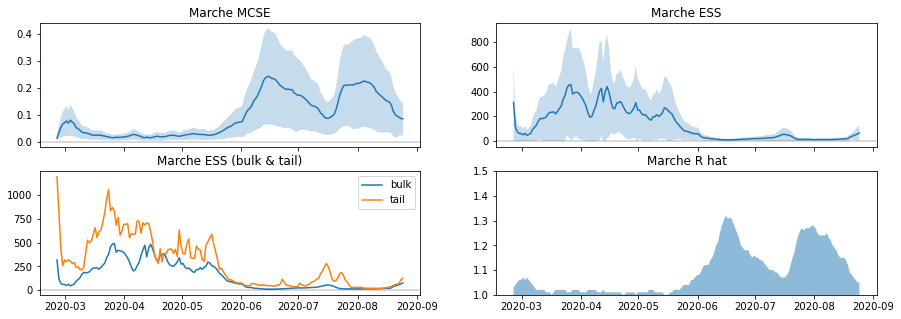

### Molise

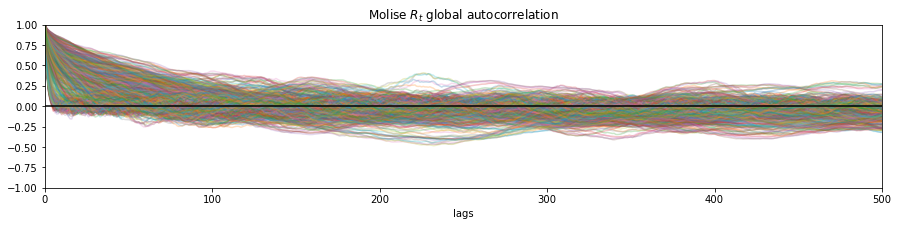

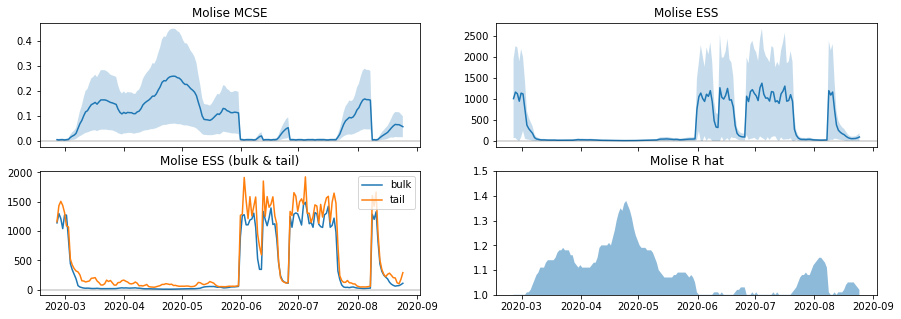

### P.A. Bolzano

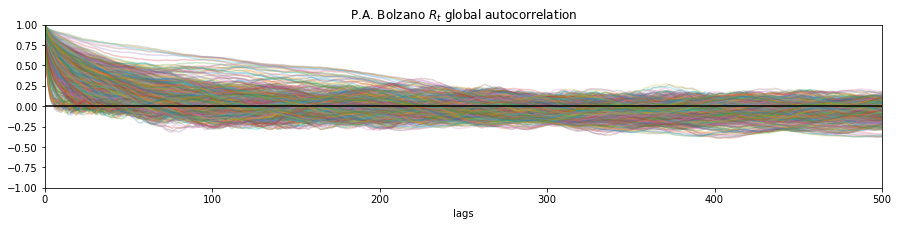

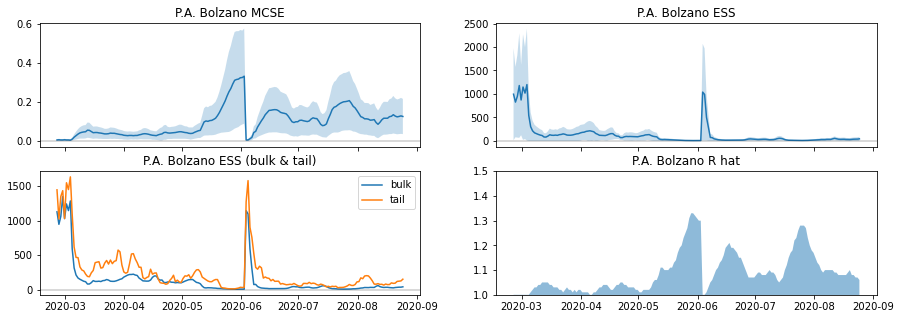

### P.A. Trento

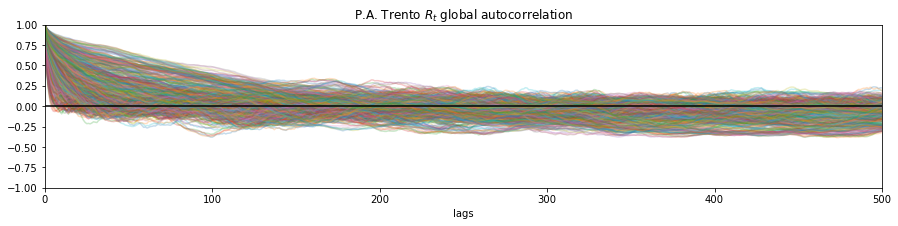

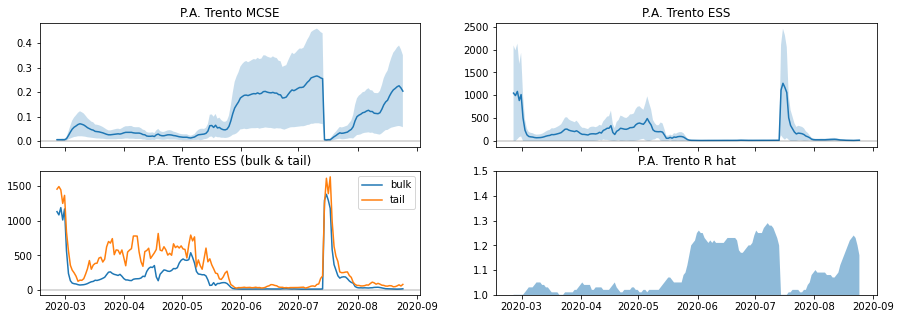

### Piemonte

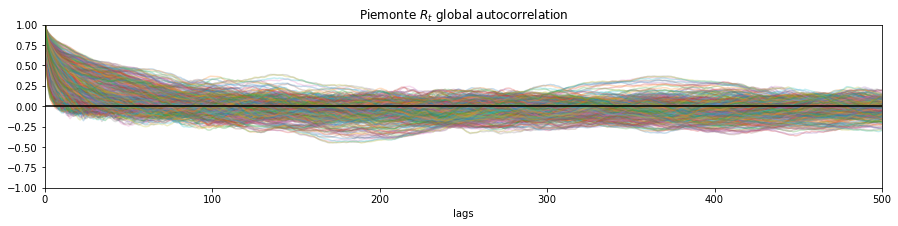

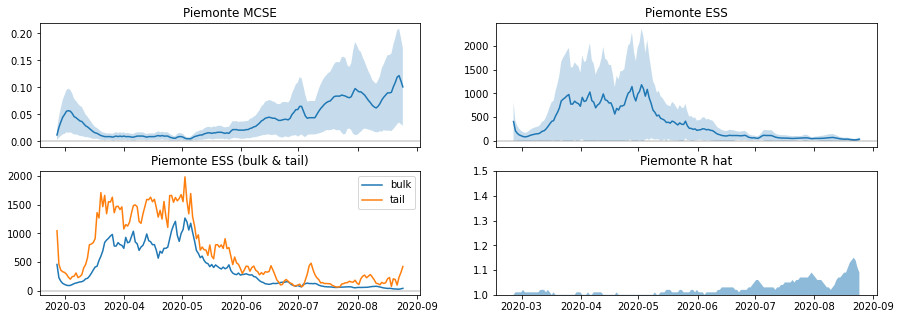

### Puglia

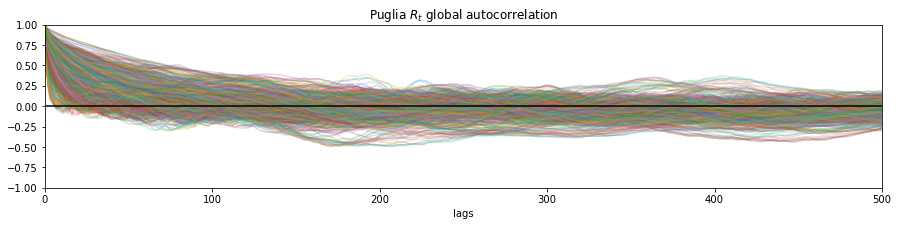

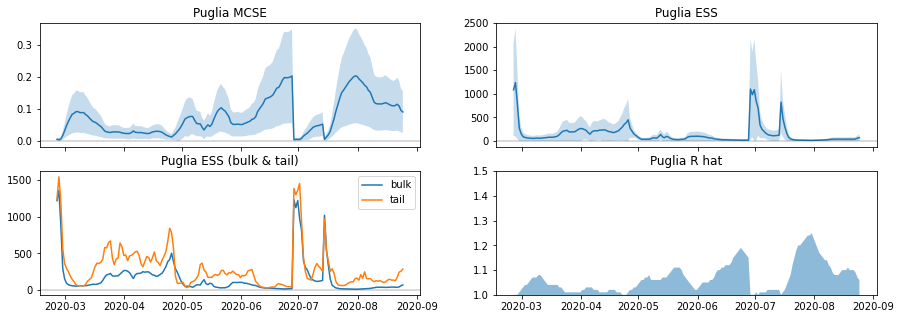

### Sardegna

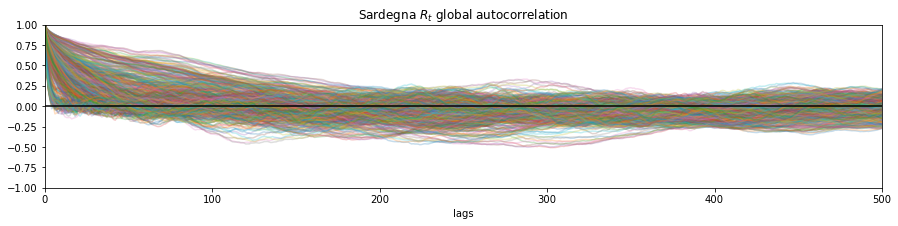

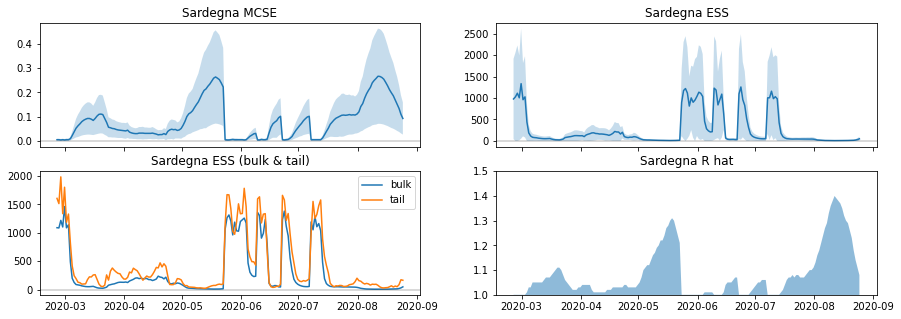

### Sicilia

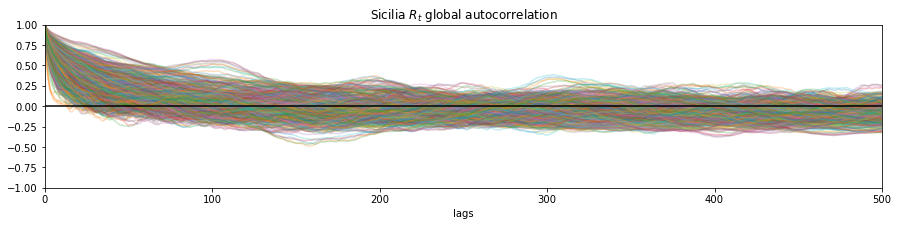

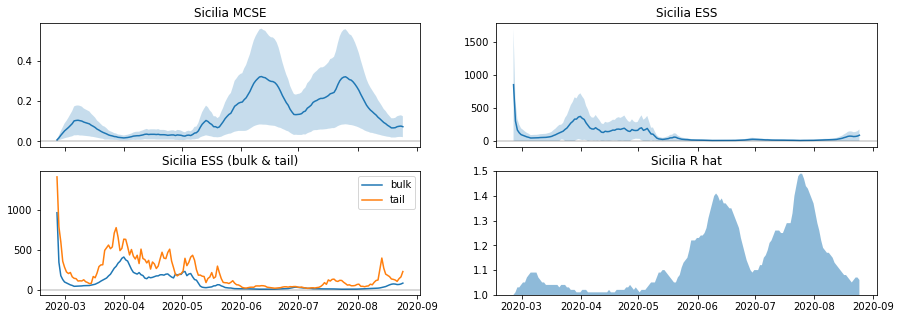

### Toscana

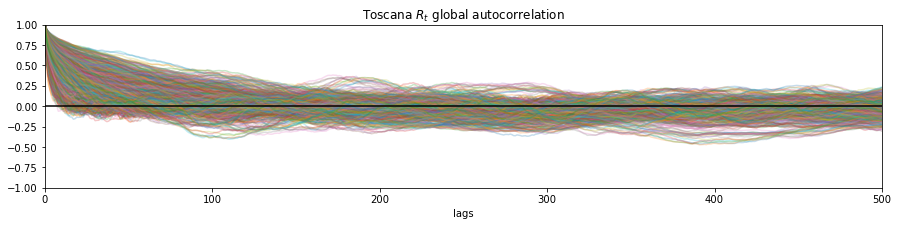

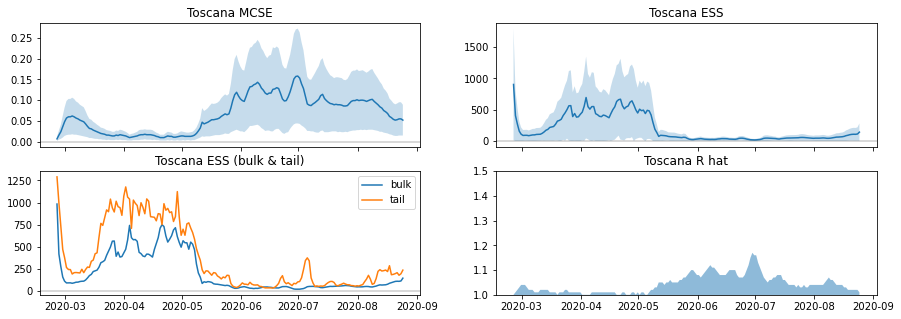

### Umbria

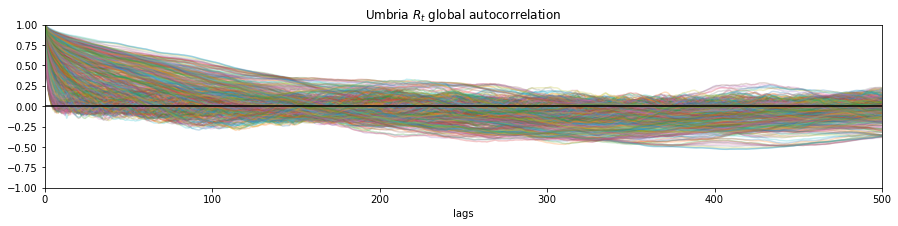

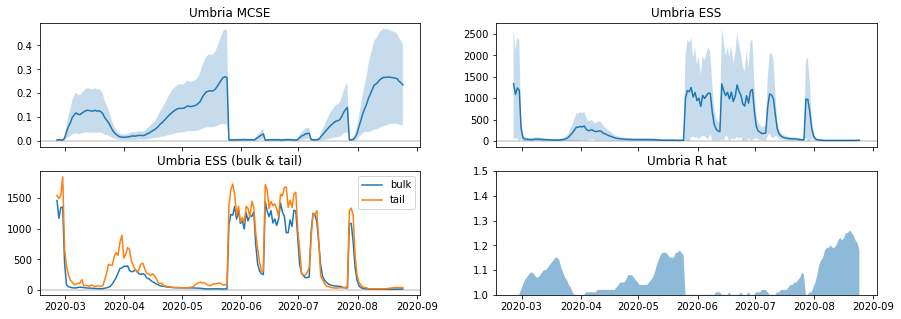

### Valle d'Aosta

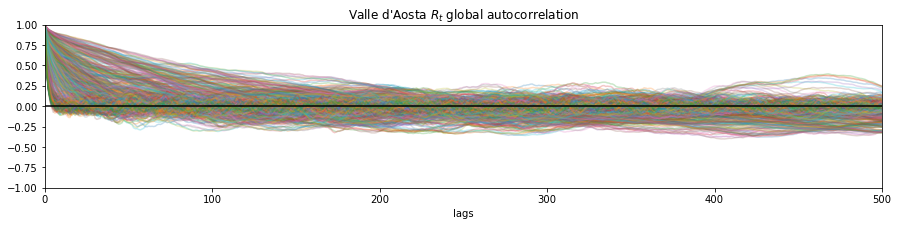

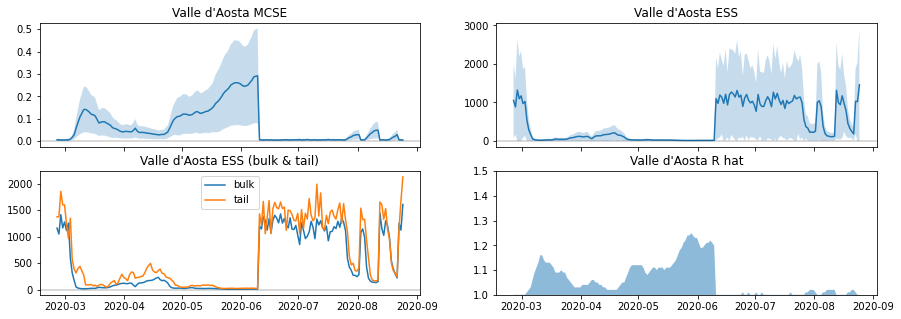

### Veneto

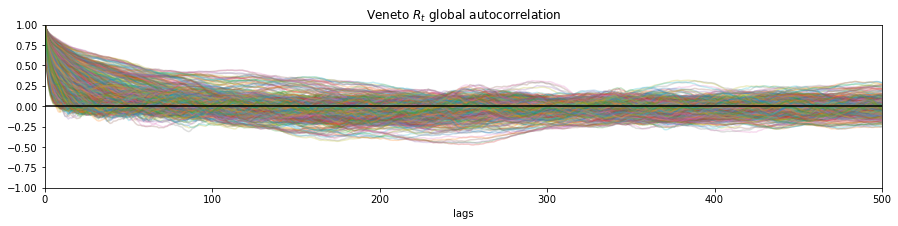

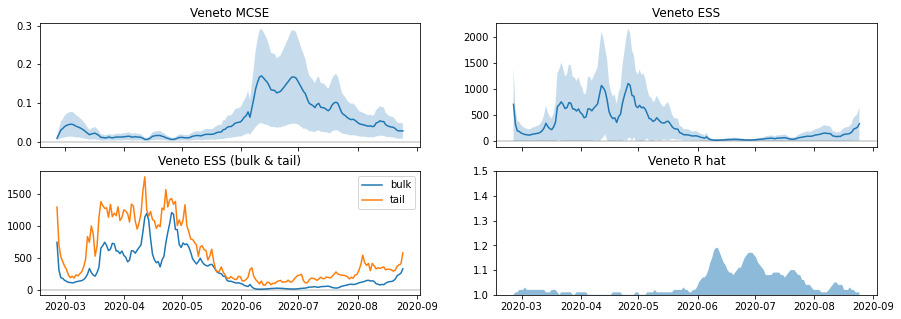

In [28]:
for r, region in enumerate(countries):
    display(Markdown(f"### {region}"))
    auto = az.autocorr(jags_posteriors["R"][r][:,warmup:,:], axis=1)
    fig, ax = plt.subplots(figsize=(15, 3))
    for c, day in enumerate(auto):
        ax.plot(day[:,:], alpha=.25, c=f"C{c}")
    ax.set_xlim(0, 500)
    ax.set_ylim(-1, 1)
    ax.axhline(0, c="k")
    ax.set_xlabel("lags")
    ax.set_title(f"{region} $R_t$ global autocorrelation")
    plt.show()
    plt.close(fig="all")
    
    
    pyjags_data_R = az.from_pyjags(
    {"R": jags_posteriors["R"][r][1:,:,:]}, 
    warmup_iterations=warmup, save_warmup=False)
    smry = az.summary(pyjags_data_R, hdi_prob=.99)
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
    ax[0,0].plot(days[1:], smry["mcse_mean"])
    ax[0,0].fill_between(
        days[1:],
        smry["mcse_mean"]-smry["mcse_sd"],
        smry["mcse_mean"]+smry["mcse_sd"],
        alpha=.25
    )
    ax[0,0].axhline(0, c="k", alpha=.2)
    ax[0,0].set_title(f"{region} MCSE")

    ax[0,1].plot(days[1:], smry["ess_mean"])
    ax[0,1].fill_between(
        days[1:],
        smry["ess_mean"]-smry["ess_sd"],
        smry["ess_mean"]+smry["ess_sd"],
        alpha=.25
    )
    ax[0,1].axhline(0, c="k", alpha=.2)
    ax[0,1].set_title(f"{region} ESS")

    ax[1,0].plot(days[1:], smry["ess_bulk"], label="bulk")
    ax[1,0].plot(days[1:], smry["ess_tail"], label="tail")
    ax[1,0].axhline(0, c="k", alpha=.2)
    ax[1,0].legend()
    ax[1,0].set_title(f"{region} ESS (bulk & tail)")

    ax[1,1].fill_between(days[1:], 0, smry["r_hat"], alpha=.5)
    ax[1,1].set_ylim(1, 1.5)
    ax[1,1].set_title(f"{region} R hat")
    plt.show()
    plt.close(fig="all")

In [29]:
auto_it = az.autocorr(jags_posteriors_italy["R"][:,warmup:,:], axis=1)

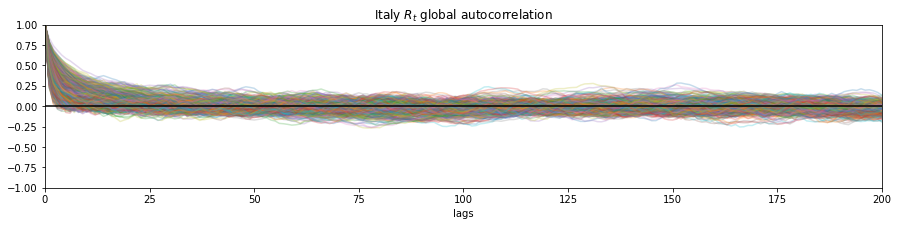

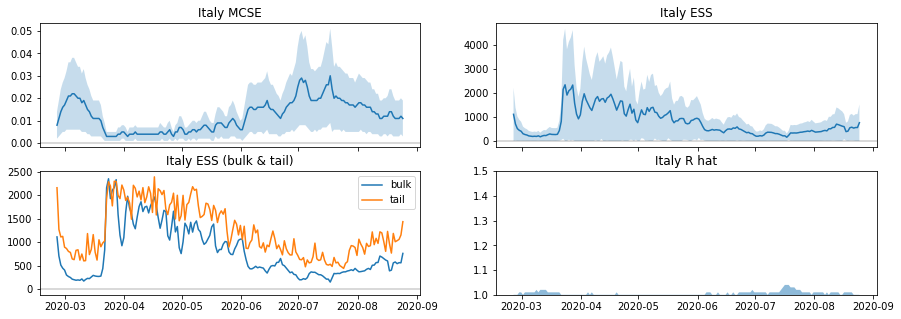

In [30]:
fig, ax = plt.subplots(figsize=(15, 3))
for day in auto_it:
    ax.plot(day[:,:], alpha=.25)
ax.set_xlim(0, 200)
ax.set_ylim(-1, 1)
ax.axhline(0, c="k")
ax.set_xlabel("lags")
ax.set_title("Italy $R_t$ global autocorrelation")
plt.show();

pyjags_data_R = az.from_pyjags(
{"R": jags_posteriors_italy["R"][1:,:,:]}, 
warmup_iterations=warmup, save_warmup=False)
smry = az.summary(pyjags_data_R, hdi_prob=.99)

fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
ax[0,0].plot(days[1:], smry["mcse_mean"])
ax[0,0].fill_between(
    days[1:],
    smry["mcse_mean"]-smry["mcse_sd"],
    smry["mcse_mean"]+smry["mcse_sd"],
    alpha=.25
)
ax[0,0].axhline(0, c="k", alpha=.2)
ax[0,0].set_title(f"Italy MCSE")

ax[0,1].plot(days[1:], smry["ess_mean"])
ax[0,1].fill_between(
    days[1:],
    smry["ess_mean"]-smry["ess_sd"],
    smry["ess_mean"]+smry["ess_sd"],
    alpha=.25
)
ax[0,1].axhline(0, c="k", alpha=.2)
ax[0,1].set_title(f"Italy ESS")

ax[1,0].plot(days[1:], smry["ess_bulk"], label="bulk")
ax[1,0].plot(days[1:], smry["ess_tail"], label="tail")
ax[1,0].axhline(0, c="k", alpha=.2)
ax[1,0].legend()
ax[1,0].set_title(f"Italy ESS (bulk & tail)")

ax[1,1].fill_between(days[1:], 0, smry["r_hat"], alpha=.5)
ax[1,1].set_ylim(1, 1.5)
ax[1,1].set_title(f"Italy R hat")
plt.show()
plt.close(fig="all")